In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-10-06 10:20:59.098471: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-10-06 10:21:00.490876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-10-06 10:21:00.491102: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-10-06 10:21:00.492418: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-10-06 10:21:00.493547: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-10-06 10:21:00.493819: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-10-06 10:21:00.495226: I tensorflow/stream_executor

In [6]:
mean_1 = [0, 1, 0, 0, 0]
cov_1 = [[1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_2 = [0, 0, 0, 0, 0]
cov_2 = [[1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

x_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
y_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
x_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)
y_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)

/home/manhducnmd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys
/home/manhducnmd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  
/home/manhducnmd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == "__main__":
/home/manhducnmd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


In [7]:
print(x_1[0])

[ 0.68256935  1.          1.21556002  1.35519296 -0.92910435]


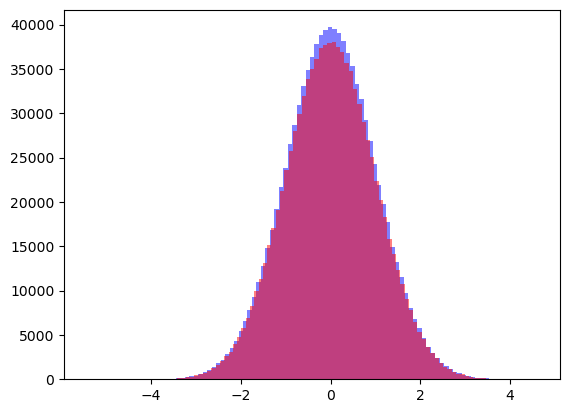

In [8]:
plt.hist(y_1[:,0], alpha = 0.5, bins = 100, color = 'b')
plt.hist(y_2[:,0], alpha = 0.5, bins = 100, color = 'r')
plt.show()

In [67]:
n_sig = 500
n_bkg = 200

#x_2 means signal and x_1 means background
x_sig_1 = x_1[0:25000]
true_label_sig_1 = np.zeros_like(x_sig_1[:,0])
x_sig_2 = x_2[0:n_sig]
true_label_sig_2 = np.ones_like(x_sig_2[:,0])
x_bkg_1 = x_1[25000:(50000+n_sig-n_bkg)]
true_label_bkg_1 = np.zeros_like(x_bkg_1[:,0])
x_bkg_2 = x_2[0:n_bkg]
true_label_bkg_2 = np.ones_like(x_bkg_2[:,0])

In [68]:
rng = np.random.default_rng()
x_sig = np.concatenate((x_sig_1, x_sig_2))
x_bkg = np.concatenate((x_bkg_1, x_bkg_2))
true_label_sig = np.concatenate((true_label_sig_1, true_label_sig_2))
true_label_bkg = np.concatenate((true_label_bkg_1, true_label_bkg_2))

indices_sig = rng.permutation(np.shape(x_sig)[0])
indices_bkg = rng.permutation(np.shape(x_bkg)[0])


x_sig = x_sig[indices_sig]
true_label_sig = true_label_sig[indices_sig]

x_bkg = x_bkg[indices_bkg]
true_label_bkg = true_label_bkg[indices_bkg]

In [69]:
print(true_label_sig)

[0. 0. 0. ... 0. 0. 0.]


In [70]:
print(np.shape(x_sig))

(25500, 5)


In [71]:
print(np.shape(x_sig[true_label_sig == 0.]))

(25000, 5)


In [72]:
print(np.shape(x_sig), np.shape(x_bkg))

(25500, 5) (25500, 5)


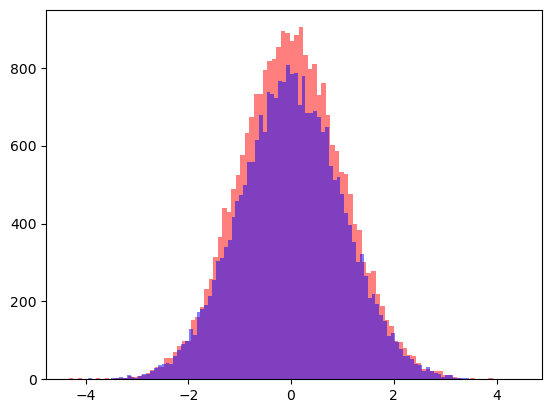

In [73]:
plt.hist(x_sig[:,0], alpha = 0.5, bins = 100, color = 'r')
plt.hist(x_bkg[:,0], alpha = 0.5, bins = 100, color = 'b')
plt.show()

Without bootstrapping

In [82]:
def CWoLA():
    input_1 = keras.layers.Input(shape = (5))
    dnn = keras.Sequential([
          keras.layers.Dense(16, activation = 'relu'),
          keras.layers.Dense(8, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    x = dnn(input_1)
    return keras.Model(         
    inputs=[input_1],
    outputs=x,)

In [83]:
print(np.shape(x_bkg))

(25500, 5)


In [84]:
y_sig = np.ones(np.shape(x_sig)[0])
y_bkg = np.zeros(np.shape(x_bkg)[0])

y_train = np.concatenate((y_sig, y_bkg))
x_train = np.concatenate((x_sig, x_bkg))
true_label_train = np.concatenate((true_label_sig, true_label_bkg))

indices_train = rng.permutation(np.shape(x_train)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]

cwola = CWoLA()
loss_object = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
cwola.fit(x_train, y_train, validation_split = 0.2,
        shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 20)  

Train on 40800 samples, validate on 10200 samples
Epoch 1/20
40800/40800 [==============================] - 1s 23us/sample - loss: 0.7262 - accuracy: 0.5017 - val_loss: 0.7176 - val_accuracy: 0.5052
Epoch 2/20
40800/40800 [==============================] - 0s 10us/sample - loss: 0.7170 - accuracy: 0.5029 - val_loss: 0.7107 - val_accuracy: 0.5072
Epoch 3/20
40800/40800 [==============================] - 0s 9us/sample - loss: 0.7106 - accuracy: 0.5023 - val_loss: 0.7060 - val_accuracy: 0.5073
Epoch 4/20
40800/40800 [==============================] - 0s 9us/sample - loss: 0.7062 - accuracy: 0.5022 - val_loss: 0.7028 - val_accuracy: 0.5069
Epoch 5/20
40800/40800 [==============================] - 0s 10us/sample - loss: 0.7030 - accuracy: 0.5019 - val_loss: 0.7006 - val_accuracy: 0.5075
Epoch 6/20
40800/40800 [==============================] - 0s 10us/sample - loss: 0.7007 - accuracy: 0.4999 - val_loss: 0.6990 - val_accuracy: 0.5082
Epoch 7/20
40800/40800 [==============================] - 

In [85]:
x_test = np.concatenate((y_1, y_2))

y_test_sig = np.ones(np.shape(y_2)[0])
y_test_bkg = np.zeros(np.shape(y_1)[0])
y_test = np.concatenate((y_test_bkg, y_test_sig))

In [86]:
x_predict = cwola.predict(x_test)

In [87]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


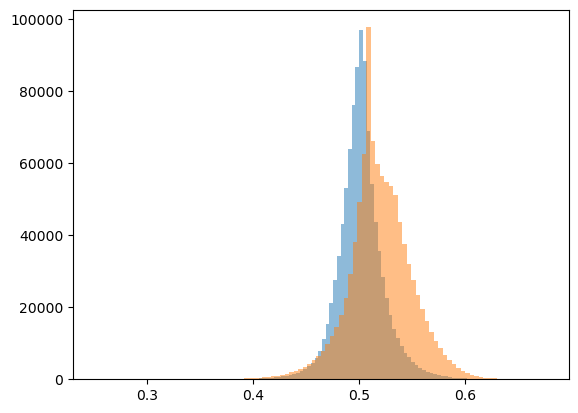

In [88]:
plt.hist(x_predict_0, bins = 100, alpha = 0.5)
plt.hist(x_predict_1, bins = 100, alpha = 0.5)
plt.show()

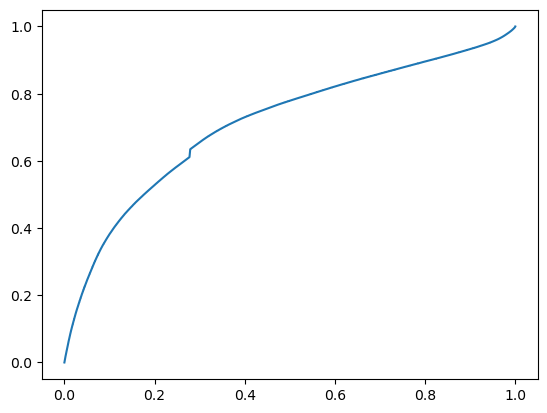

0.7120515128119999


In [89]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

With bootstrapping

In [90]:
y_sig = np.ones(np.shape(x_sig)[0])
y_bkg = np.zeros(np.shape(x_bkg)[0])

y_train = np.concatenate((y_sig, y_bkg))
x_train = np.concatenate((x_sig, x_bkg))
true_label_train = np.concatenate((true_label_sig, true_label_bkg))

indices_train = rng.permutation(np.shape(x_train)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]

cwola_2 = CWoLA()
loss_object = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
cwola_2.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
for i in range(10):
    cwola_2.fit(x_train, y_train, validation_split = 0.2,
            shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 2)  
    
    predict = (cwola_2.predict(x_train)).flatten()
    
    predict_array = np.zeros_like(y_train)
    predict_array[predict >= np.percentile(predict, 50)] = 1
    y_train = predict_array
    print(y_train)
    

Train on 40800 samples, validate on 10200 samples
Epoch 1/2
40800/40800 [==============================] - 1s 18us/sample - loss: 0.7108 - accuracy: 0.5014 - val_loss: 0.7066 - val_accuracy: 0.5000
Epoch 2/2
40800/40800 [==============================] - 0s 9us/sample - loss: 0.7055 - accuracy: 0.5026 - val_loss: 0.7027 - val_accuracy: 0.5010
[1. 1. 0. ... 0. 0. 0.]
Train on 40800 samples, validate on 10200 samples
Epoch 1/2
40800/40800 [==============================] - 0s 10us/sample - loss: 0.5901 - accuracy: 0.9198 - val_loss: 0.5743 - val_accuracy: 0.9193
Epoch 2/2
40800/40800 [==============================] - 0s 9us/sample - loss: 0.5617 - accuracy: 0.9141 - val_loss: 0.5474 - val_accuracy: 0.9088
[1. 1. 0. ... 0. 0. 0.]
Train on 40800 samples, validate on 10200 samples
Epoch 1/2
40800/40800 [==============================] - 0s 10us/sample - loss: 0.5276 - accuracy: 0.9323 - val_loss: 0.5097 - val_accuracy: 0.9327
Epoch 2/2
40800/40800 [==============================] - 0s 10us

In [91]:
x_predict = cwola_2.predict(x_test)

In [92]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]

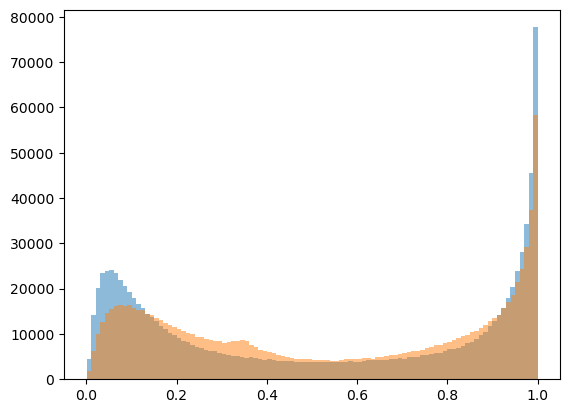

In [93]:
plt.hist(x_predict_0, bins = 100, alpha = 0.5)
plt.hist(x_predict_1, bins = 100, alpha = 0.5)
plt.show()

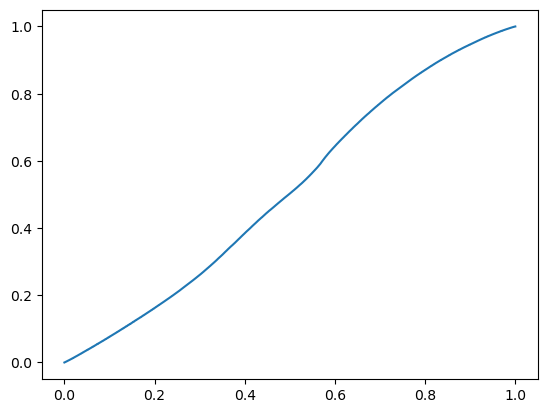

0.5119532376485001


In [94]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [64]:
print(epsilon_s)

[0.08502543 0.2728005  0.669796  ]
